In [ ]:
"""

Post a message that says, what % ownership we have in total for each pool, and how large in base asset terms that pool is.

Aggregation is by pool instead of destination vault, because if we have multiple destination vaults for the same pool
"""

from mainnet_launch.pages.risk_metrics.percent_ownership_by_destination import (
    fetch_readable_our_tvl_by_destination,
)
from mainnet_launch.constants import *

from mainnet_launch.database.schema.full import *


from mainnet_launch.database.schema.ensure_tables_are_current.using_onchain.order_dependent.update_destinations_states_table import (
    build_lp_token_spot_and_safe_price_calls,
)

from mainnet_launch.database.postgres_operations import get_full_table_as_df, _exec_sql_and_cache

from mainnet_launch.data_fetching.get_state_by_block import (
    get_raw_state_by_blocks,
    safe_normalize_with_bool_success,
    build_blocks_to_use,
    get_state_by_one_block,
)

from mainnet_launch.slack_messages.post_message import post_message_with_table


def _fetch_rich_tvl_by_destination(chain: ChainData) -> pd.DataFrame:
    block = chain.get_block_near_top()
    destinations = get_full_table_as_df(Destinations)
    our_tvl_by_destination_df = fetch_readable_our_tvl_by_destination(chain, block).copy()
    our_tvl_by_destination_df = pd.merge(
        our_tvl_by_destination_df,
        destinations[
            ["pool", "destination_vault_address", "underlying", "destination_vault_decimals", "underlying_symbol"]
        ],
        left_on="destination_vault_address",
        right_on="destination_vault_address",
        how="left",
    )
    our_tvl_by_destination_df["our_total_shares"] = our_tvl_by_destination_df.apply(
        lambda row: int(row["totalSupply"]) / 10 ** row["destination_vault_decimals"], axis=1
    )
    our_tvl_by_destination_df["total_shares"] = our_tvl_by_destination_df.apply(
        lambda row: int(row["underlyingTotalSupply"]) / 10 ** row["destination_vault_decimals"], axis=1
    )

    autopool_destinations = get_full_table_as_df(AutopoolDestinations)
    autopool_destinations["autopool"] = autopool_destinations["autopool_vault_address"].map(
        {a.autopool_eth_addr: a for a in ALL_AUTOPOOLS}
    )
    autopool_destinations["autopool_name"] = autopool_destinations["autopool_vault_address"].map(
        {a.autopool_eth_addr: a.name for a in ALL_AUTOPOOLS}
    )

    our_tvl_by_destination_df = pd.merge(
        our_tvl_by_destination_df,
        autopool_destinations[["destination_vault_address", "autopool", "autopool_name"]],
        left_on="destination_vault_address",
        right_on="destination_vault_address",
        how="left",
    )

    our_tvl_by_destination_df["base_asset_symbol"] = our_tvl_by_destination_df.apply(
        lambda row: row["autopool"].base_asset_symbol, axis=1
    )
    our_tvl_by_destination_df["chain_name"] = chain.name
    return our_tvl_by_destination_df


def _fetch_destination_safe_and_spot_prices_for_slack(our_tvl_by_destination_df: pd.DataFrame) -> pd.DataFrame:
    all_states = {}

    for autopool in ALL_AUTOPOOLS:

        this_autopool_df = our_tvl_by_destination_df[our_tvl_by_destination_df["autopool"] == autopool].copy()
        if this_autopool_df.empty:
            continue

        calls = build_lp_token_spot_and_safe_price_calls(
            destination_addresses=this_autopool_df["destination_vault_address"].tolist(),
            lp_token_addresses=this_autopool_df["underlying"].tolist(),
            pool_addresses=this_autopool_df["pool"].tolist(),
            autopool=autopool,
        )
        state = get_state_by_one_block(calls, autopool.chain.get_block_near_top(), autopool.chain)
        all_states.update(state)

    state_df = pd.DataFrame(all_states).T.rename(columns={0: "lp_token_spot_price", 1: "lp_token_safe_price"})
    state_df.index = state_df.index.get_level_values(0)
    state_df.reset_index(inplace=True)
    state_df = state_df.rename(columns={"index": "destination_vault_address"})
    return state_df


def fetch_destination_percent_ownership_with_sizes() -> pd.DataFrame:
    """Fetches live data, ~15 seconds"""
    all_readable_dfs = []

    for chain in ALL_CHAINS:
        our_tvl_by_destination_df = _fetch_rich_tvl_by_destination(chain)

        state_df = _fetch_destination_safe_and_spot_prices_for_slack(our_tvl_by_destination_df)

        readable_df = pd.merge(
            our_tvl_by_destination_df,
            state_df,
            left_on="destination_vault_address",
            right_on="destination_vault_address",
            how="left",
        )

        readable_df["our_safe_tvl"] = (readable_df["our_total_shares"] * readable_df["lp_token_safe_price"]).round()
        readable_df["total_tvl"] = (readable_df["total_shares"] * readable_df["lp_token_safe_price"]).round()

        all_readable_dfs.append(readable_df)

    final_readable_df = pd.concat(all_readable_dfs, ignore_index=True)

    final_readable_df["total_tvl"] = final_readable_df.apply(
        lambda row: f"{row['total_tvl']:,.0f} {row['base_asset_symbol']}", axis=1
    )
    return final_readable_df


def post_ownership_exposure_message():

    final_readable_df = fetch_destination_percent_ownership_with_sizes()

    display_cols = [
        "underlying_symbol",
        "percent_ownership",
        "total_tvl",
        "destination_vault_address",
        "holding_autopools",
    ]

    dest_to_autopools = final_readable_df.groupby("destination_vault_address")["autopool_name"].apply(tuple).to_dict()
    final_readable_df["holding_autopools"] = final_readable_df["destination_vault_address"].map(dest_to_autopools)

    high_exposure_df = (
        final_readable_df[final_readable_df["percent_ownership"] > 50][display_cols]
        .sort_values(by="percent_ownership", ascending=False)
        .drop_duplicates()
    )
    high_exposure_df = high_exposure_df[["underlying_symbol", "percent_ownership", "total_tvl", "holding_autopools"]]

    post_message_with_table(
        "Tokemak Ownership by Pool",
        high_exposure_df[["underlying_symbol", "percent_ownership", "total_tvl"]],
    )

/Users/pb/Library/Caches/pypoetry/virtualenvs/mainnet-launch-FtycU18g-py3.10/lib/python3.10/site-packages/web3/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-10-20 15:40:21.475 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-20 15:40:21.476 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-20 15:40:21.476 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-20 15:40:21.477 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2025-10-20 15:40:21.478 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStor

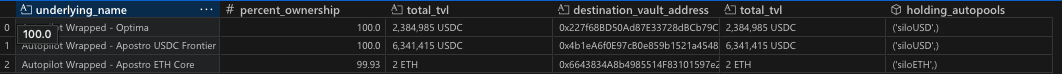

what are those?

In [3]:
destinations = get_full_table_as_df(Destinations)
destinations

,destination_vault_address,chain_id,exchange_name,name,symbol,pool_type,pool,underlying,underlying_symbol,underlying_name,denominated_in,destination_vault_decimals
0,0xa767F35BF1d51f4ab7432188DfE6324934c9CCbD,1,none,Tokemak-USD Coin-Savings USDS,toke-USDC-sUSDS,self,0xa3931d71877C0E7a3148CB7Eb4463524FEc27fbD,0xa3931d71877C0E7a3148CB7Eb4463524FEc27fbD,sUSDS,Savings USDS,0xA0b86991c6218b36c1d19D4a2e9Eb0cE3606eB48,18
1,0x6643834A8b4985514F83101597e2dCd2ae3b0ce7,1,silo,Tokemak-Wrapped Ether-Autopilot Wrapped - Apos...,toke-WETH-apWrap-apcETH,sToken,0x0E80F6Db7fc8e5966828eaE36874B62dC8A47dc6,0x0E80F6Db7fc8e5966828eaE36874B62dC8A47dc6,apWrap-apcETH,Autopilot Wrapped - Apostro ETH Core,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,18
2,0x4142e3a17391676C66DDf1285E43889F168EE237,1,balancerV3,Tokemak-Wrapped Ether-Balancer osETH-waWETH,toke-WETH-osETH-waWETH,balV3,0x57c23c58B1D8C3292c15BEcF07c62C5c52457A42,0x57c23c58B1D8C3292c15BEcF07c62C5c52457A42,osETH-waWETH,Balancer osETH-waWETH,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,18
3,0xB84c580c005A5F633C8CF6eecAf5b0a8314EC5c4,1,curve,Tokemak-Wrapped Ether-pxETH/stETH,toke-WETH-pxsteth,curveNG,0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6,0x6951bDC4734b9f7F3E1B74afeBC670c736A0EDB6,pxsteth,pxETH/stETH,0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2,18
4,0x116b3e86f2b04c21605c5fC4b95Ba6A82dBF8F3E,1,inverse,Tokemak-Dola USD Stablecoin-Staked Dola,toke-DOLA-sDOLA,self,0xb45ad160634c528Cc3D2926d9807104FA3157305,0xb45ad160634c528Cc3D2926d9807104FA3157305,sDOLA,Staked Dola,0x865377367054516e17014CcdED1e7d814EDC9ce4,18
...,...,...,...,...,...,...,...,...,...,...,...,...
230,0x5DFFAE9a249db6fc61906BaE2c1e640045602ee7,9745,aave,Tokemak-USDT0-Wrapped Aave Plasma sUSDe,toke-USDT0-waPlasUSDe,aTokenStataV3,0xA31C7dDAD8F1D66D037C4EE76F8fb725f927Bc25,0xA31C7dDAD8F1D66D037C4EE76F8fb725f927Bc25,waPlasUSDe,Wrapped Aave Plasma sUSDe,0xB8CE59FC3717ada4C02eaDF9682A9e934F625ebb,18
231,0xdE4D6c5416ff7584373020fa24F160d193F84855,9745,aave,Tokemak-USDT0-Wrapped Aave Plasma USDT0,toke-USDT0-waPlaUSDT0,aTokenStataV3,0xE0126F0c4451B2B917064A93040fd4770D6774b5,0xE0126F0c4451B2B917064A93040fd4770D6774b5,waPlaUSDT0,Wrapped Aave Plasma USDT0,0xB8CE59FC3717ada4C02eaDF9682A9e934F625ebb,6
232,0xF3dE68350bf01d90FE9eD09A20B20E984E78d217,9745,euler,Tokemak-USDT0-EVK Vault eUSDT0-9,toke-USDT0-eUSDT0-9,eVault,0x4718484ac9dc07fbbC078561e8f8Ef29e2a369CD,0x4718484ac9dc07fbbC078561e8f8Ef29e2a369CD,eUSDT0-9,EVK Vault eUSDT0-9,0xB8CE59FC3717ada4C02eaDF9682A9e934F625ebb,6
233,0x3DB1fe3B1839798aA22fA0143D326D3693728915,1,curve,Tokemak-Dola USD Stablecoin-DOLA/wstUSR,toke-DOLA-DOLAwstUSR,curveNG,0x64273624eb57c5cA961d366CBF3968e760Bf0452,0x64273624eb57c5cA961d366CBF3968e760Bf0452,DOLAwstUSR,DOLA/wstUSR,0x865377367054516e17014CcdED1e7d814EDC9ce4,18


In [4]:
high_exposure_df.to_markdown()

"|    | underlying_symbol       |   percent_ownership | total_tvl      | holding_autopools        |\n|---:|:------------------------|--------------------:|:---------------|:-------------------------|\n|  0 | apWrap-soUSDC           |              100    | 2,385,023 USDC | ('siloUSD',)             |\n|  1 | apWrap-apfUSDC          |              100    | 6,341,490 USDC | ('siloUSD',)             |\n|  2 | apWrap-apcETH           |               99.93 | 2 ETH          | ('siloETH',)             |\n|  3 | pxethweth               |               96.07 | 639 ETH        | ('autoETH',)             |\n|  4 | reusdsdola              |               75.37 | 2,547,096 DOLA | ('autoDOLA',)            |\n| 34 | Balancer rETH-Aave wETH |               71.72 | 524 ETH        | ('baseETH',)             |\n|  5 | pxsteth                 |               65.49 | 1,121 ETH      | ('dineroETH', 'autoETH') |\n|  7 | weeth-ng                |               63.27 | 5,718 ETH      | ('autoLRT', 'autoETH')   |\

In [5]:
high_exposure_df

,underlying_symbol,percent_ownership,total_tvl,holding_autopools
0,apWrap-soUSDC,100.00,"2,385,023 USDC","(siloUSD,)"
1,apWrap-apfUSDC,100.00,"6,341,490 USDC","(siloUSD,)"
2,apWrap-apcETH,99.93,2 ETH,"(siloETH,)"
3,pxethweth,96.07,639 ETH,"(autoETH,)"
4,reusdsdola,75.37,"2,547,096 DOLA","(autoDOLA,)"
34,Balancer rETH-Aave wETH,71.72,524 ETH,"(baseETH,)"
5,pxsteth,65.49,"1,121 ETH","(dineroETH, autoETH)"
7,weeth-ng,63.27,"5,718 ETH","(autoLRT, autoETH)"
9,Surge Fluid wstETH-wETH,57.93,"5,648 ETH","(autoETH,)"


Message posted successfully, status code: 200
{'blocks': [{'text': {'text': '```\n'
                              '| underlying_symbol       |   percent_ownership '
                              '| total_tvl      |\n'
                              '|:------------------------|--------------------:|:---------------|\n'
                              '| apWrap-soUSDC           |              100    '
                              '| 2,385,023 USDC |\n'
                              '| apWrap-apfUSDC          |              100    '
                              '| 6,341,490 USDC |\n'
                              '| apWrap-apcETH           |               99.93 '
                              '| 2 ETH          |\n'
                              '| pxethweth               |               96.07 '
                              '| 639 ETH        |\n'
                              '| reusdsdola              |               75.37 '
                              '| 2,547,096 DOLA |\n'
           

In [13]:
from mainnet_launch.slack_messages.post_message import post_slack_message
from blockkit import Message, Section, MarkdownText


from tabulate import tabulate


as_markdown = tabulate(high_exposure_df)
as_markdown

"--  -----------------------  ------  --------------  ------------------------\n 0  apWrap-soUSDC            100     2,385,023 USDC  ('siloUSD',)\n 1  apWrap-apfUSDC           100     6,341,490 USDC  ('siloUSD',)\n 2  apWrap-apcETH             99.93  2 ETH           ('siloETH',)\n 3  pxethweth                 96.07  639 ETH         ('autoETH',)\n 4  reusdsdola                75.37  2,547,096 DOLA  ('autoDOLA',)\n34  Balancer rETH-Aave wETH   71.72  524 ETH         ('baseETH',)\n 5  pxsteth                   65.49  1,121 ETH       ('dineroETH', 'autoETH')\n 7  weeth-ng                  63.27  5,718 ETH       ('autoLRT', 'autoETH')\n 9  Surge Fluid wstETH-wETH   57.93  5,648 ETH       ('autoETH',)\n--  -----------------------  ------  --------------  ------------------------"

In [14]:
post_slack_message(Message(blocks=[Section(text=MarkdownText(text=as_markdown))]))

Message posted successfully, status code: 200
{'blocks': [{'text': {'text': '--  -----------------------  ------  '
                              '--------------  ------------------------\n'
                              ' 0  apWrap-soUSDC            100     2,385,023 '
                              "USDC  ('siloUSD',)\n"
                              ' 1  apWrap-apfUSDC           100     6,341,490 '
                              "USDC  ('siloUSD',)\n"
                              ' 2  apWrap-apcETH             99.93  2 '
                              "ETH           ('siloETH',)\n"
                              ' 3  pxethweth                 96.07  639 '
                              "ETH         ('autoETH',)\n"
                              ' 4  reusdsdola                75.37  2,547,096 '
                              "DOLA  ('autoDOLA',)\n"
                              '34  Balancer rETH-Aave wETH   71.72  524 '
                              "ETH         ('baseETH',)\n"
          